In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Transformer Model Training - Complete Pipeline
# This notebook demonstrates training a Transformer-based model with proper visualization and evaluation

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Convert to pandas for easier exploration
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features: {train_df.columns.tolist()}")


Loading IMDb dataset...


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 25000
Test samples: 25000
Features: ['text', 'label']


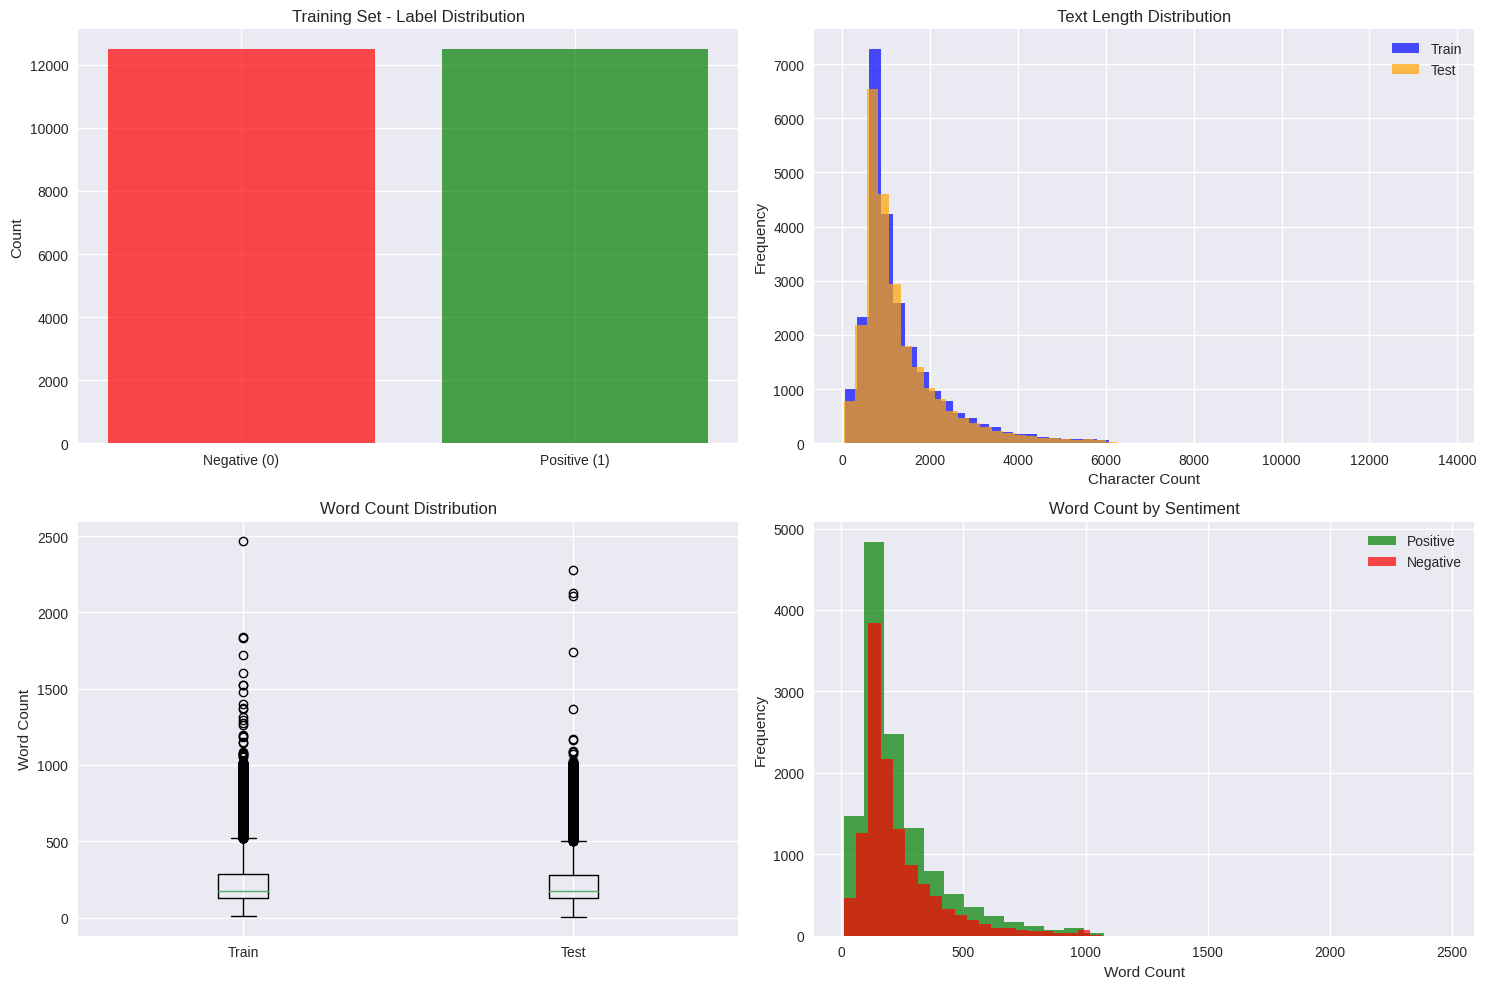


=== SAMPLE TEXTS ===
Positive Review:
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is ...

Negative Review:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything sh

In [4]:

# =============================================================================
# 2. DATA VISUALIZATION
# =============================================================================

# Set up plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Label distribution in training set
train_labels = train_df['label'].value_counts()
axes[0, 0].bar(['Negative (0)', 'Positive (1)'], train_labels.values, color=['red', 'green'], alpha=0.7)
axes[0, 0].set_title('Training Set - Label Distribution')
axes[0, 0].set_ylabel('Count')

# Plot 2: Text length distribution
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

axes[0, 1].hist(train_df['text_length'], bins=50, alpha=0.7, label='Train', color='blue')
axes[0, 1].hist(test_df['text_length'], bins=50, alpha=0.7, label='Test', color='orange')
axes[0, 1].set_title('Text Length Distribution')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Plot 3: Word count distribution
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

axes[1, 0].boxplot([train_df['word_count'], test_df['word_count']], labels=['Train', 'Test'])
axes[1, 0].set_title('Word Count Distribution')
axes[1, 0].set_ylabel('Word Count')

# Plot 4: Sample text lengths by label
pos_lengths = train_df[train_df['label'] == 1]['word_count']
neg_lengths = train_df[train_df['label'] == 0]['word_count']

axes[1, 1].hist(pos_lengths, bins=30, alpha=0.7, label='Positive', color='green')
axes[1, 1].hist(neg_lengths, bins=30, alpha=0.7, label='Negative', color='red')
axes[1, 1].set_title('Word Count by Sentiment')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Display sample texts
print("\n=== SAMPLE TEXTS ===")
print("Positive Review:")
print(train_df[train_df['label'] == 1]['text'].iloc[0][:500] + "...")
print("\nNegative Review:")
print(train_df[train_df['label'] == 0]['text'].iloc[0][:500] + "...")


In [5]:

# =============================================================================
# 3. DATA PREPROCESSING
# =============================================================================

# Create train/validation split (80/20)
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['label']
)

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

# Initialize tokenizer
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization parameters
MAX_LENGTH = 256

class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])  # Ensure label is an integer
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = IMDbDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = IMDbDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

# Create data loaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Debug: Check a sample batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Input IDs: {sample_batch['input_ids'].shape}")
print(f"Attention mask: {sample_batch['attention_mask'].shape}")
print(f"Labels: {sample_batch['labels'].shape}")
print(f"Labels dtype: {sample_batch['labels'].dtype}")
print(f"Sample labels: {sample_batch['labels'][:5]}")


Training samples: 20000
Validation samples: 5000
Test samples: 25000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training batches: 1250
Validation batches: 313
Test batches: 1563

Sample batch shapes:
Input IDs: torch.Size([16, 256])
Attention mask: torch.Size([16, 256])
Labels: torch.Size([16])
Labels dtype: torch.int64
Sample labels: tensor([0, 0, 1, 1, 0])


In [6]:

# =============================================================================
# 4. MODEL DEFINITION
# =============================================================================

class TransformerClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate=0.3):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # For DistilBERT, use the last hidden state and apply mean pooling
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Apply attention mask to ignore padding tokens and compute mean pooling
        attention_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * attention_mask_expanded, 1)
        sum_mask = torch.clamp(attention_mask_expanded.sum(1), min=1e-9)
        pooled_output = sum_embeddings / sum_mask
        
        output = self.dropout(pooled_output)
        return self.classifier(output)

# Initialize model
model = TransformerClassifier(MODEL_NAME, num_classes=2)
model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


2025-06-04 07:14:01.543437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749021241.735013      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749021241.790600      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Total parameters: 66,364,418
Trainable parameters: 66,364,418


In [7]:

# =============================================================================
# 5. TRAINING SETUP
# =============================================================================

# Training parameters
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 1000

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)


In [8]:

# =============================================================================
# 6. TRAINING LOOP WITH LOGGING
# =============================================================================

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rates': []
}

print("Starting training...")
print("=" * 50)

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    correct_train_predictions = 0
    total_train_predictions = 0
    
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Debug: Print shapes for first batch
        if epoch == 0 and batch_idx == 0:
            print(f"Debug - Batch shapes:")
            print(f"Input IDs: {input_ids.shape}")
            print(f"Attention mask: {attention_mask.shape}")
            print(f"Labels: {labels.shape}")
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask)
        
        # Debug: Print output shape for first batch
        if epoch == 0 and batch_idx == 0:
            print(f"Model outputs shape: {outputs.shape}")
            print(f"Labels shape: {labels.shape}")
            print(f"Labels content: {labels}")
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step()
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_predictions += labels.size(0)
        correct_train_predictions += (predicted == labels).sum().item()
        
        # Print progress every 500 batches
        if (batch_idx + 1) % 500 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, LR: {current_lr:.2e}')
    
    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions
    
    # Validation phase
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)
    history['learning_rates'].append(scheduler.get_last_lr()[0])
    
    print(f'Epoch [{epoch+1}/{EPOCHS}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    print('-' * 50)

print("Training completed!")


Starting training...
Debug - Batch shapes:
Input IDs: torch.Size([16, 256])
Attention mask: torch.Size([16, 256])
Labels: torch.Size([16])
Model outputs shape: torch.Size([16, 2])
Labels shape: torch.Size([16])
Labels content: tensor([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Epoch [1/3], Batch [500/1250], Loss: 0.2359, LR: 1.00e-05
Epoch [1/3], Batch [1000/1250], Loss: 0.3322, LR: 2.00e-05
Epoch [1/3]
Train Loss: 0.3743, Train Acc: 0.8236
Val Loss: 0.2481, Val Acc: 0.8978
--------------------------------------------------
Epoch [2/3], Batch [500/1250], Loss: 0.0252, LR: 1.45e-05
Epoch [2/3], Batch [1000/1250], Loss: 0.0230, LR: 1.09e-05
Epoch [2/3]
Train Loss: 0.2126, Train Acc: 0.9232
Val Loss: 0.2539, Val Acc: 0.9130
--------------------------------------------------
Epoch [3/3], Batch [500/1250], Loss: 0.6165, LR: 5.45e-06
Epoch [3/3], Batch [1000/1250], Loss: 0.1391, LR: 1.82e-06
Epoch [3/3]
Train Loss: 0.1205, Train Acc: 0.9640
Val Loss: 0.3059, Val Acc: 0

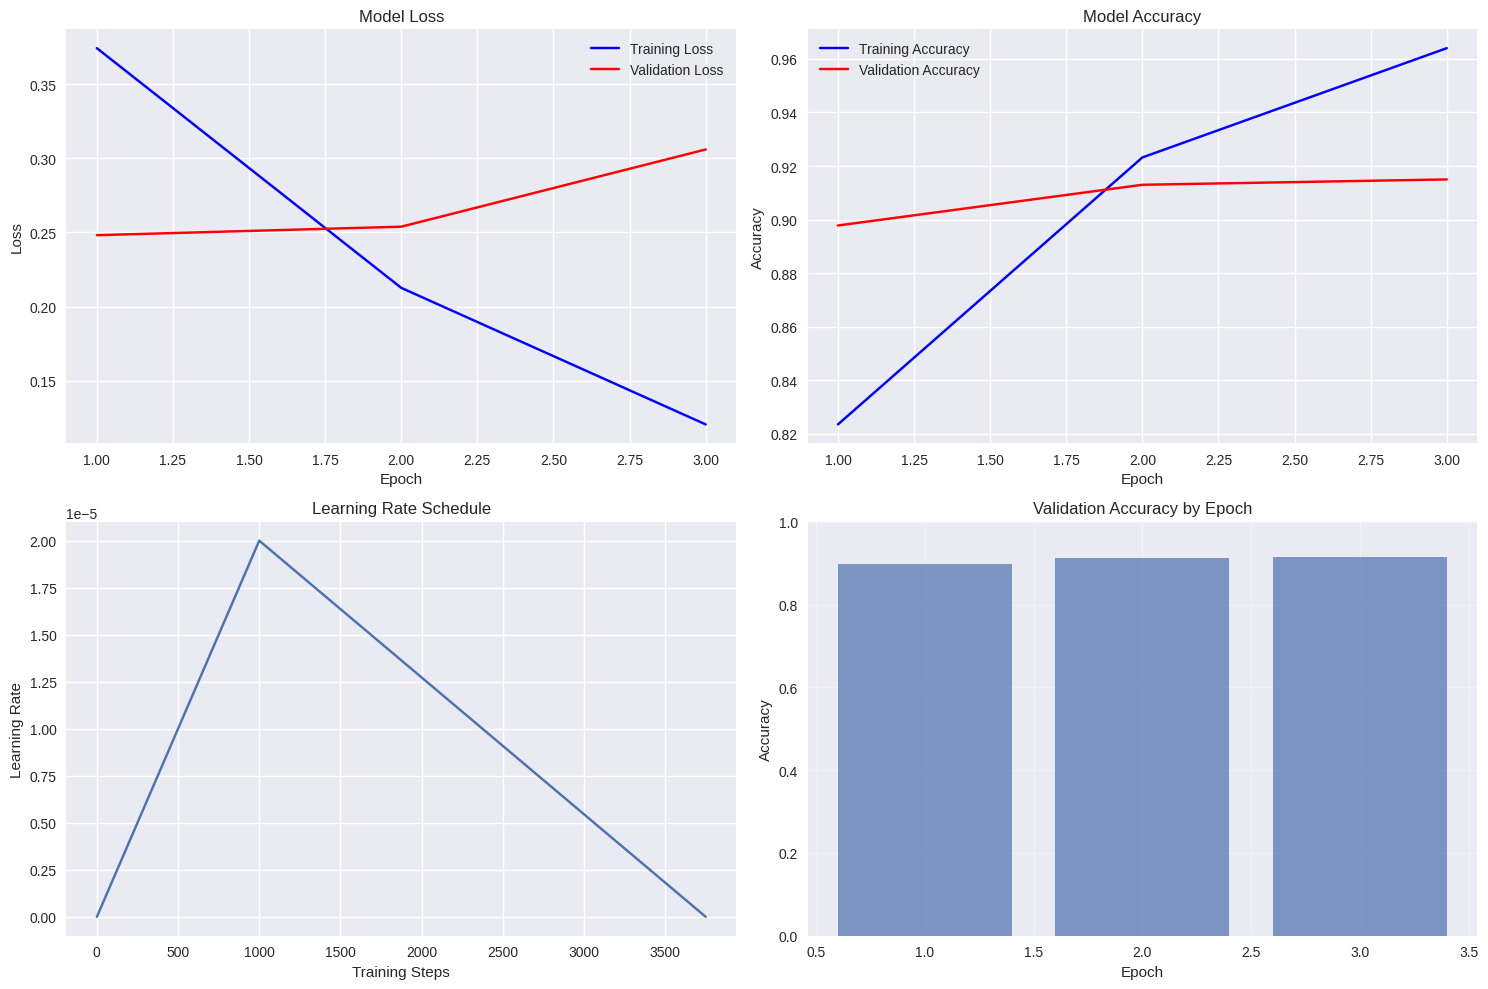

In [9]:

# =============================================================================
# 7. TRAINING VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss curves
epochs_range = range(1, EPOCHS + 1)
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', label='Training Loss')
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Accuracy curves
axes[0, 1].plot(epochs_range, history['train_acc'], 'b-', label='Training Accuracy')
axes[0, 1].plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Learning rate schedule
total_steps_plot = list(range(len(train_loader) * EPOCHS))
lr_values = []
for epoch in range(EPOCHS):
    for batch in range(len(train_loader)):
        step = epoch * len(train_loader) + batch
        if step < len(total_steps_plot):
            # Approximate LR schedule
            if step < WARMUP_STEPS:
                lr = LEARNING_RATE * (step / WARMUP_STEPS)
            else:
                lr = LEARNING_RATE * (1 - (step - WARMUP_STEPS) / (total_steps - WARMUP_STEPS))
            lr_values.append(lr)

axes[1, 0].plot(total_steps_plot[:len(lr_values)], lr_values)
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Training Steps')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].grid(True)

# Plot 4: Training metrics comparison
metrics_df = pd.DataFrame({
    'Epoch': epochs_range,
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})

axes[1, 1].bar(epochs_range, history['val_acc'], alpha=0.7, label='Validation Accuracy')
axes[1, 1].set_title('Validation Accuracy by Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:

# =============================================================================
# 8. MODEL EVALUATION
# =============================================================================

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
    
    return np.array(actual_labels), np.array(predictions)

# Get predictions for test set
print("Evaluating model on test set...")
test_labels_actual, test_predictions = get_predictions(model, test_loader, device)

# Calculate comprehensive metrics
accuracy = accuracy_score(test_labels_actual, test_predictions)
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels_actual, test_predictions, average=None
)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    test_labels_actual, test_predictions, average='macro'
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    test_labels_actual, test_predictions, average='weighted'
)

# Create results dataframe
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Score': [accuracy, precision_macro, recall_macro, f1_macro,
              precision_weighted, recall_weighted, f1_weighted]
})

print("\n=== MODEL EVALUATION RESULTS ===")
print(results_df.round(4))

# Per-class metrics
class_names = ['Negative', 'Positive']
class_results = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n=== PER-CLASS METRICS ===")
print(class_results.round(4))

# Detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(test_labels_actual, test_predictions, 
                          target_names=class_names, digits=4))


Evaluating model on test set...

=== MODEL EVALUATION RESULTS ===
                 Metric   Score
0              Accuracy  0.9098
1     Precision (Macro)  0.9098
2        Recall (Macro)  0.9098
3      F1-Score (Macro)  0.9098
4  Precision (Weighted)  0.9098
5     Recall (Weighted)  0.9098
6   F1-Score (Weighted)  0.9098

=== PER-CLASS METRICS ===
      Class  Precision  Recall  F1-Score  Support
0  Negative     0.9068  0.9134    0.9101    12500
1  Positive     0.9128  0.9061    0.9094    12500

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    Negative     0.9068    0.9134    0.9101     12500
    Positive     0.9128    0.9061    0.9094     12500

    accuracy                         0.9098     25000
   macro avg     0.9098    0.9098    0.9098     25000
weighted avg     0.9098    0.9098    0.9098     25000



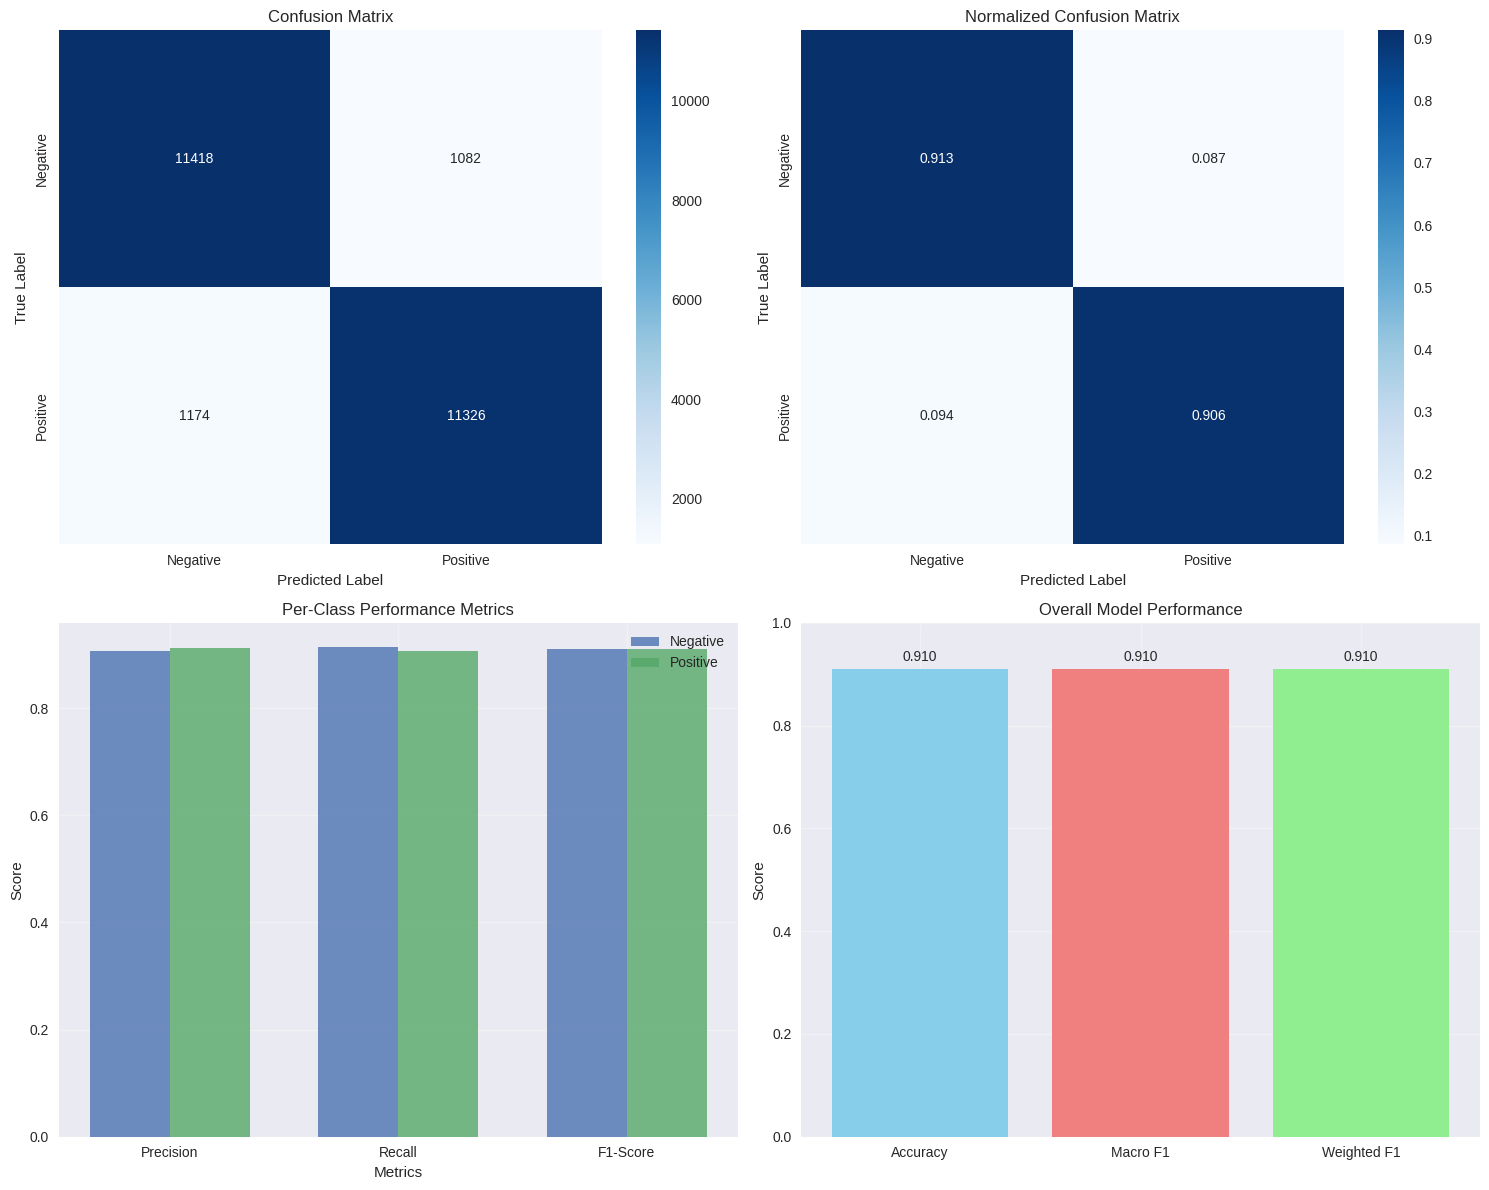

In [11]:

# =============================================================================
# 9. CONFUSION MATRIX AND ADDITIONAL VISUALIZATIONS
# =============================================================================

# Confusion Matrix
cm = confusion_matrix(test_labels_actual, test_predictions)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('True Label')

# Plot 2: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0, 1])
axes[0, 1].set_title('Normalized Confusion Matrix')
axes[0, 1].set_xlabel('Predicted Label')
axes[0, 1].set_ylabel('True Label')

# Plot 3: Metrics Comparison
metrics_names = ['Precision', 'Recall', 'F1-Score']
negative_scores = [precision[0], recall[0], f1[0]]
positive_scores = [precision[1], recall[1], f1[1]]

x = np.arange(len(metrics_names))
width = 0.35

axes[1, 0].bar(x - width/2, negative_scores, width, label='Negative', alpha=0.8)
axes[1, 0].bar(x + width/2, positive_scores, width, label='Positive', alpha=0.8)
axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Per-Class Performance Metrics')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_names)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Overall Performance Summary
overall_metrics = ['Accuracy', 'Macro F1', 'Weighted F1']
overall_scores = [accuracy, f1_macro, f1_weighted]

bars = axes[1, 1].bar(overall_metrics, overall_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1, 1].set_title('Overall Model Performance')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, overall_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [12]:

# =============================================================================
# 10. FINAL SUMMARY
# =============================================================================

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print(f"Model: {MODEL_NAME}")
print(f"Dataset: IMDb Movie Reviews")
print(f"Training Samples: {len(train_texts):,}")
print(f"Validation Samples: {len(val_texts):,}")
print(f"Test Samples: {len(test_texts):,}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Max Sequence Length: {MAX_LENGTH}")

print(f"\nFinal Results:")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score (Macro): {f1_macro:.4f}")
print(f"Test F1-Score (Weighted): {f1_weighted:.4f}")

# Best epoch based on validation accuracy
best_epoch = np.argmax(history['val_acc']) + 1
print(f"\nBest Validation Accuracy: {max(history['val_acc']):.4f} (Epoch {best_epoch})")

print("\nModel training and evaluation completed successfully!")


TRAINING SUMMARY
Model: distilbert-base-uncased
Dataset: IMDb Movie Reviews
Training Samples: 20,000
Validation Samples: 5,000
Test Samples: 25,000
Epochs: 3
Batch Size: 16
Learning Rate: 2e-05
Max Sequence Length: 256

Final Results:
Test Accuracy: 0.9098
Test F1-Score (Macro): 0.9098
Test F1-Score (Weighted): 0.9098

Best Validation Accuracy: 0.9150 (Epoch 3)

Model training and evaluation completed successfully!
